In [35]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

In [10]:
# Load the data and parse dates
non_farm_data = pd.read_csv('PAYNSA.csv', parse_dates=['DATE'])
non_farm_data.set_index('DATE', inplace=True)
non_farm_data.index = non_farm_data.index.strftime('%Y-%m')
non_farm_data

,PAYNSA
DATE,
1939-01,29296
1939-02,29394
1939-03,29804
1939-04,29786
1939-05,30145
...,...
2024-05,158842
2024-06,159341
2024-07,158399


In [68]:
total_population = pd.read_csv('POPTOTUSA647NWDB.csv',parse_dates=['DATE'])
total_population.set_index('DATE', inplace=True)
total_population.index = total_population.index.strftime('%Y-%m')
total_population

,POPTOTUSA647NWDB
DATE,
1960-01,180671000
1961-01,183691000
1962-01,186538000
1963-01,189242000
1964-01,191889000
...,...
2019-01,328329953
2020-01,331526933
2021-01,332048977


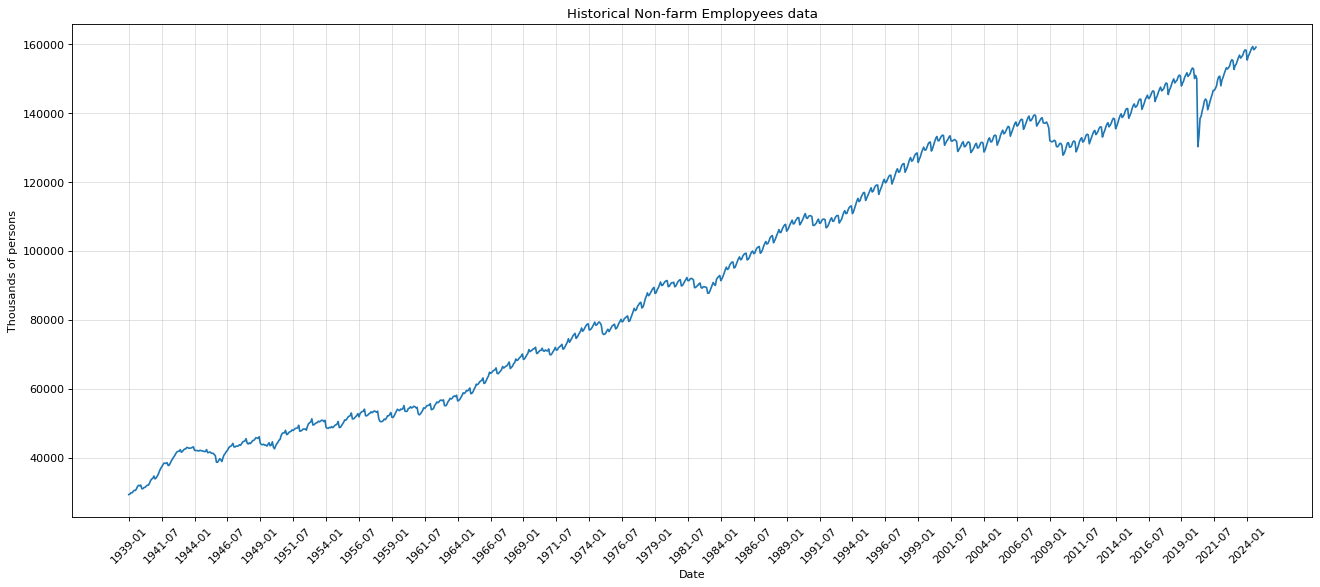

In [32]:
# Plot the figure
plt.figure(figsize=(20,8), dpi=80)
plt.plot(non_farm_data.index, non_farm_data['PAYNSA'])
plt.title('Historical Non-farm Emplopyees data')
plt.yticks()
plt.xticks(non_farm_data.index[::30], rotation = 45)
plt.ylabel('Thousands of persons')
plt.xlabel('Date')
plt.grid(alpha=0.4) 
plt.show()

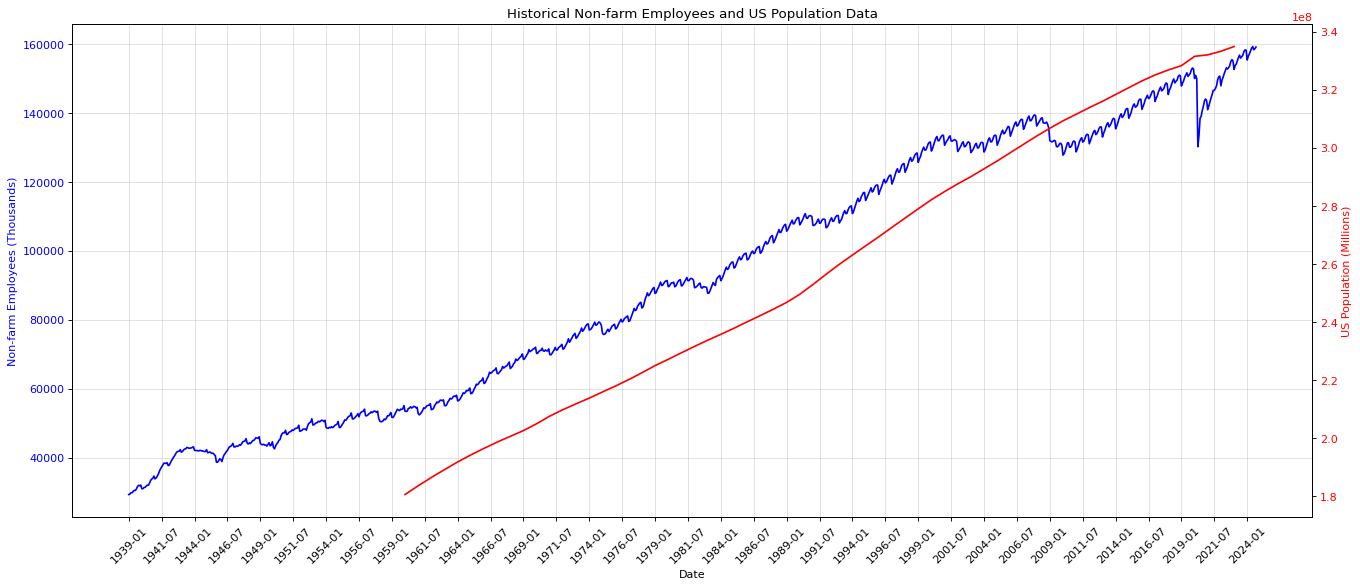

In [71]:
# Assuming `non_farm_data` and `population_data` have different date ranges

fig, ax1 = plt.subplots(figsize=(20, 8), dpi=80)

# Plot the non-farm employees data on the left y-axis (ax1)
ax1.plot(non_farm_data.index, non_farm_data['PAYNSA'], color='b', label='Non-farm Employees (Thousands)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Non-farm Employees (Thousands)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.set_xticks(non_farm_data.index[::30])
ax1.set_xticklabels(non_farm_data.index[::30], rotation=45)

# Create a secondary y-axis for the population data
ax2 = ax1.twinx()
ax2.plot(total_population.index, total_population['POPTOTUSA647NWDB'], color='r', label='US Population (Millions)')
ax2.set_ylabel('US Population (Millions)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Set the title
plt.title('Historical Non-farm Employees and US Population Data')

# Add grid for readability
ax1.grid(alpha=0.4)

# Show the plot
plt.show()


##### AD-Fuller Test

In [73]:
# Run the adfuller test
time_series = non_farm_data['PAYNSA'].dropna()

result = adfuller(time_series)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(result[1]<0.05)

ADF Statistic: 0.13897515326502352
p-value: 0.9686235485908465
False


In [13]:
# Apply first-order differencing
df_diff1 = non_farm_data['PAYNSA'].diff().dropna()

# Perform ADF test on differenced data
result_diff1 = adfuller(df_diff1)
print(f'ADF Statistic (1st Difference): {result_diff1[0]}')
print(f'p-value (1st Difference): {result_diff1[1]}')
print(result_diff1[1]<0.05)

ADF Statistic (1st Difference): -8.183795431744441
p-value (1st Difference): 7.999713484582715e-13
True


In [14]:
time_series_diff = time_series.diff().dropna()

# Re-run the ADF test on the differenced data
result = adfuller(time_series_diff)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')

ADF Statistic: -8.183795431744441
p-value: 7.999713484582715e-13


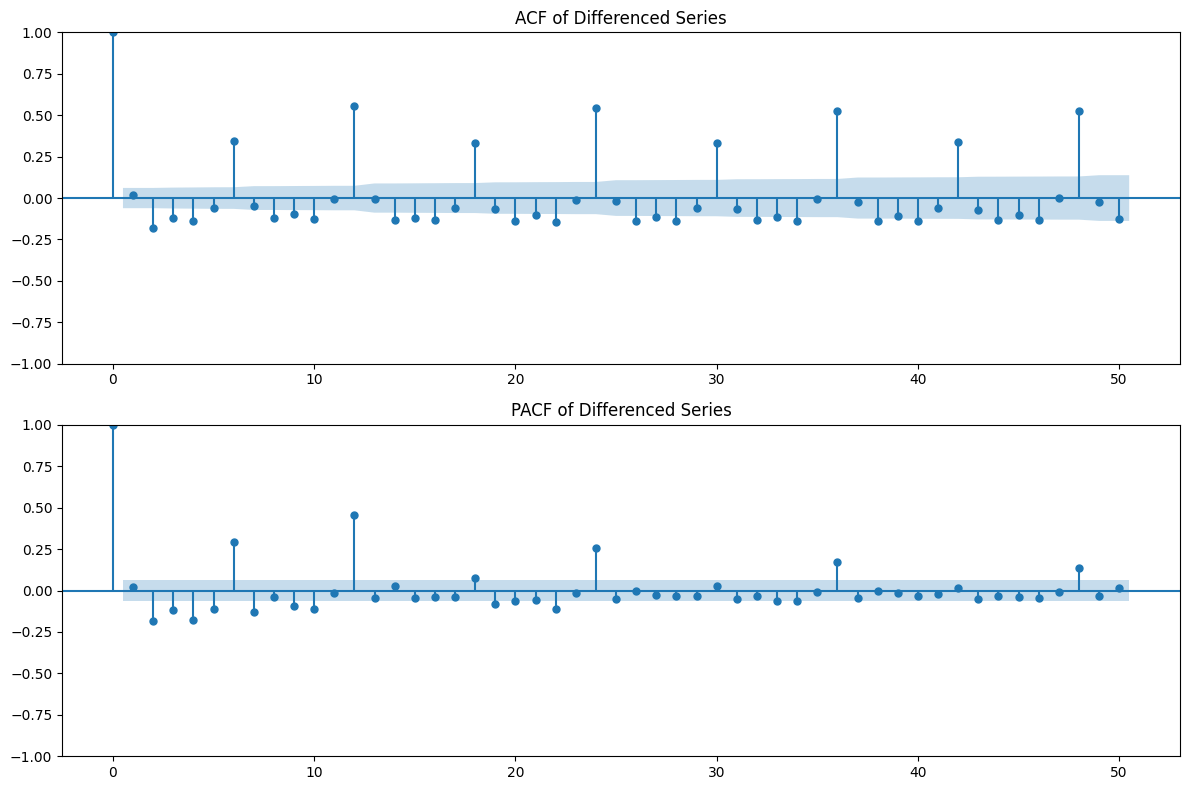

In [78]:
# Plot ACF
fig, ax = plt.subplots(2,1, figsize=(12,8))
plot_acf(time_series_diff.dropna(), lags=50, ax=ax[0])
ax[0].set_title('ACF of Differenced Series')

# Plot PACF
plot_pacf(time_series_diff.dropna(), lags=50, ax=ax[1])
ax[1].set_title('PACF of Differenced Series')

plt.tight_layout()
plt.show()

##### SARIMAX Model 

In [21]:
model = sm.tsa.statespace.SARIMAX(
    non_farm_data['PAYNSA'],
    order=(1, 1, 1),            # Replace with your determined (p, d, q)
    seasonal_order=(1, 1, 1, 12),  # Replace with your determined (P, D, Q, s)
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
results = model.fit()
print(results.summary())

C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                             PAYNSA   No. Observations:                 1029
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               -8061.480
Date:                            Mon, 14 Oct 2024   AIC                          16132.961
Time:                                    23:18:45   BIC                          16157.509
Sample:                                01-01-1939   HQIC                         16142.290
                                     - 09-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3343      0.070     -4.747      0.000      -0.472      -0.196
ma.L1          0.4413      0.069   

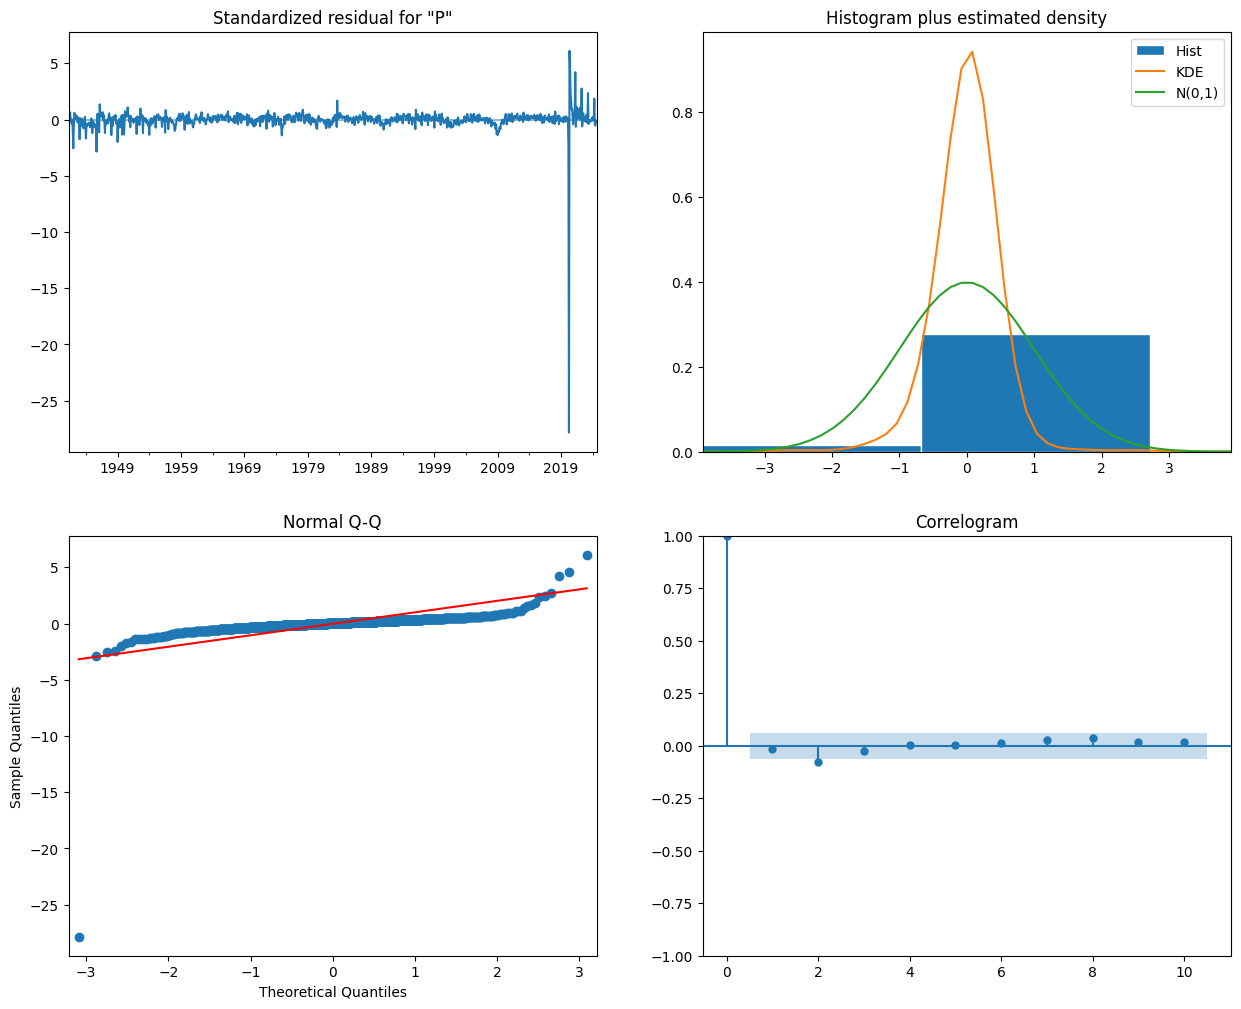

In [22]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [24]:
forecast = results.get_forecast(steps=1)
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()
print(f"Forecasted Payroll for Next Month: {forecast_mean.iloc[0]:.2f}")
print(f"95% Confidence Interval: [{forecast_conf_int.iloc[0, 0]:.2f}, {forecast_conf_int.iloc[0, 1]:.2f}]")

Forecasted Payroll for Next Month: 160218.76
95% Confidence Interval: [158777.36, 161660.17]


In [27]:
# Input the actual value for September, 2024
actual_value = 254000
predicted_value = forecast_mean.iloc[0]

# Calculate the percentage difference
percentage_difference = ((actual_value - predicted_value) / actual_value) * 100
print(f"Forecasted value for September 2024: {predicted_value}")
print(f"Actual value for September 2024: {actual_value}")
print(f"Percentage difference: {percentage_difference:.2f}%")

Forecasted value for September 2024: 160218.7640215512
Actual value for September 2024: 254000
Percentage difference: 36.92%


In [28]:
mae = mean_absolute_error([actual_value], [predicted_value])
mse = mean_squared_error([actual_value], [predicted_value])
rmse = np.sqrt(mse)

print(f'Mean Absolute Error (MAE): {mae:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Mean Absolute Error (MAE): 93781.24
Root Mean Squared Error (RMSE): 93781.24


##### To find out the optimal SARIMAX model

In [30]:
import itertools

# Define p,d,q ranges
p = q = range(0, 3)
d = [1] 
pdq = list(itertools.product(p, d, q))

# Define seasonal P, D, Q ranges
P = Q = range(0, 2)
D = [1] 
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in itertools.product(P, D, Q)]

# Grid search
aic_values = []
params = []

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(
                non_farm_data['PAYNSA'],
                order=param,
                seasonal_order=param_seasonal,
                enforce_stationarity=False,
                enforce_invertibility=False
            )
            results = mod.fit(disp=False)
            aic_values.append(results.aic)
            params.append((param, param_seasonal))
            print(f'SARIMA{param}x{param_seasonal[:-1]}12 - AIC:{results.aic}')
        except:
            continue

# Find the parameters with minimal AIC
min_aic = min(aic_values)
best_params = params[aic_values.index(min_aic)]

print(f'\nBest SARIMA{best_params[0]}x{best_params[1][:-1]}12 model - AIC:{min_aic}')

C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Local

SARIMA(0, 1, 0)x(0, 1, 0)12 - AIC:16907.07285691912
SARIMA(0, 1, 0)x(0, 1, 1)12 - AIC:16153.73368517433
SARIMA(0, 1, 0)x(1, 1, 0)12 - AIC:16462.0010543683


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Local

SARIMA(0, 1, 0)x(1, 1, 1)12 - AIC:16154.308740202585
SARIMA(0, 1, 1)x(0, 1, 0)12 - AIC:16889.094778865132


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Local

SARIMA(0, 1, 1)x(0, 1, 1)12 - AIC:16133.571833353479


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 1, 1)x(1, 1, 0)12 - AIC:16458.724315809657


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 1, 1)x(1, 1, 1)12 - AIC:16134.365176096991
SARIMA(0, 1, 2)x(0, 1, 0)12 - AIC:16860.388691650347


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Local

SARIMA(0, 1, 2)x(0, 1, 1)12 - AIC:16107.588405127168


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 1, 2)x(1, 1, 0)12 - AIC:16451.79507475867


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(0, 1, 2)x(1, 1, 1)12 - AIC:16107.918311244195
SARIMA(1, 1, 0)x(0, 1, 0)12 - AIC:16905.793994045463


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Local

SARIMA(1, 1, 0)x(0, 1, 1)12 - AIC:16150.152492935043


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(1, 1, 0)x(1, 1, 0)12 - AIC:16443.84031191872


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(1, 1, 0)x(1, 1, 1)12 - AIC:16150.919510872922


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)x(0, 1, 0)12 - AIC:16848.079857790955


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_

SARIMA(1, 1, 1)x(0, 1, 1)12 - AIC:16132.026722893192
SARIMA(1, 1, 1)x(1, 1, 0)12 - AIC:16423.730922315965


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(1, 1, 1)x(1, 1, 1)12 - AIC:16132.960712554348


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(1, 1, 2)x(0, 1, 0)12 - AIC:16861.989644547306


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(1, 1, 2)x(0, 1, 1)12 - AIC:16109.088590486816


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(1, 1, 2)x(1, 1, 0)12 - AIC:16437.62983458564


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(1, 1, 2)x(1, 1, 1)12 - AIC:16109.412438133037
SARIMA(2, 1, 0)x(0, 1, 0)12 - AIC:16876.5427642519


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\Local

SARIMA(2, 1, 0)x(0, 1, 1)12 - AIC:16138.942091115317


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(2, 1, 0)x(1, 1, 0)12 - AIC:16420.013663533515


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(2, 1, 0)x(1, 1, 1)12 - AIC:16123.78575824852


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(2, 1, 1)x(0, 1, 0)12 - AIC:16878.49172901565


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(2, 1, 1)x(0, 1, 1)12 - AIC:16125.242496867388


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(2, 1, 1)x(1, 1, 0)12 - AIC:16421.95790477816


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(2, 1, 1)x(1, 1, 1)12 - AIC:16125.705501617562


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(2, 1, 2)x(0, 1, 0)12 - AIC:16863.91505462773


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(2, 1, 2)x(0, 1, 1)12 - AIC:16110.823792417406


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMA(2, 1, 2)x(1, 1, 0)12 - AIC:16427.622653703143


C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


SARIMA(2, 1, 2)x(1, 1, 1)12 - AIC:16111.174415047739

Best SARIMA(0, 1, 2)x(0, 1, 1)12 model - AIC:16107.588405127168


In [31]:
# Best parameters from grid search
best_order = best_params[0]
best_seasonal_order = best_params[1]

# Refit the model
model = sm.tsa.statespace.SARIMAX(
    non_farm_data['PAYNSA'],
    order=best_order,
    seasonal_order=best_seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False
)
results = model.fit()
print(results.summary())

C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                       
Dep. Variable:                               PAYNSA   No. Observations:                 1029
Model:             SARIMAX(0, 1, 2)x(0, 1, [1], 12)   Log Likelihood               -8049.794
Date:                              Mon, 14 Oct 2024   AIC                          16107.588
Time:                                      23:25:12   BIC                          16127.223
Sample:                                  01-01-1939   HQIC                         16115.051
                                       - 09-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0787      0.007     11.593      0.000       0.065       0.092
ma.L2         -0.11

##### Looking for the historical maximum differences

In [36]:
# Training window (number of observations to use for training at each step)
train_window = 120  # For example, use 10 years of data if monthly data (10*12)

# Forecast horizon
forecast_horizon = 1  # Forecasting 1 month ahead

In [37]:
# Lists to store actual values, predicted values, and differences
actual_values = []
predicted_values = []
differences = []
dates = []

In [38]:
# Start the rolling forecast
for i in tqdm(range(train_window, len(non_farm_data) - forecast_horizon + 1)):
    # Define training and test sets
    train_data = non_farm_data.iloc[i - train_window:i]['PAYNSA']
    test_data = non_farm_data.iloc[i:i + forecast_horizon]['PAYNSA']
    
    # Fit SARIMA model on training data
    model = SARIMAX(train_data,
                    order=(1, 1, 1),     
                    seasonal_order=(1, 1, 1, 12), 
                    enforce_stationarity=False,
                    enforce_invertibility=False)
    results = model.fit(disp=False)
    
    # Forecast
    forecast = results.forecast(steps=forecast_horizon)
    
    # Store the results
    actual = test_data.iloc[0]
    predicted = forecast.iloc[0]
    difference = abs(actual - predicted)
    
    actual_values.append(actual)
    predicted_values.append(predicted)
    differences.append(difference)
    dates.append(test_data.index[0])

  0%|          | 0/909 [00:00<?, ?it/s]C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
  0%|          | 1/909 [00:00<06:27,  2.34it/s]C:\Users\67003\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
C:\Users

In [54]:
results_df = pd.DataFrame({
    'Date': dates,
    'Actual': actual_values,
    'Predicted': predicted_values,
    'Difference': differences
}).set_index('Date')

In [56]:
# Handle potential division by zero
results_df['Actual'].replace(0, np.nan, inplace=True)

# Calculate percentage differences
results_df['Percentage Difference'] = 100 * results_df['Difference'] / results_df['Actual']

C:\Users\67003\AppData\Local\Temp\ipykernel_9948\4175090180.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  results_df['Actual'].replace(0, np.nan, inplace=True)


In [58]:
# Find maximum percentage difference
max_percentage_difference = results_df['Percentage Difference'].max()
max_percentage_date = results_df['Percentage Difference'].idxmax()

print(f"The maximum percentage difference is {max_percentage_difference:.2f}%")
print(max_percentage_date)


The maximum percentage difference is 132.22%
2020-05


In [45]:
# Find the maximum difference
max_difference = results_df['Difference'].max()
max_difference_date = results_df['Difference'].idxmax()

print(f"The maximum difference is {max_difference:.2f} on {max_difference_date.date()}")

The maximum difference is 176416.26 


In [79]:
sorted_results = results_df.sort_values(by='Percentage Difference', ascending=False)
top_5_differences = sorted_results.head(5)
print("Top 5 Percentage Differences:")
top_5_differences

Top 5 Percentage Differences:


,Actual,Predicted,Difference,Percentage Difference
Date,,,,
2020-05,133422,-42994.262741,176416.262741,132.224268
2020-04,130253,151735.273467,21482.273467,16.492728
2022-04,151434,131247.903574,20186.096426,13.329963
2021-04,144402,149675.012136,5273.012136,3.651620
2020-06,138507,134201.514845,4305.485155,3.108496


In [51]:
# Error metrics
mae = mean_absolute_error(results_df['Actual'], results_df['Predicted'])
rmse = np.sqrt(mean_squared_error(results_df['Actual'], results_df['Predicted']))
mape = np.mean(results_df['Percentage Difference'].dropna())

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

Mean Absolute Error (MAE): 426.69
Root Mean Squared Error (RMSE): 5943.13
Mean Absolute Percentage Error (MAPE): 0.40%


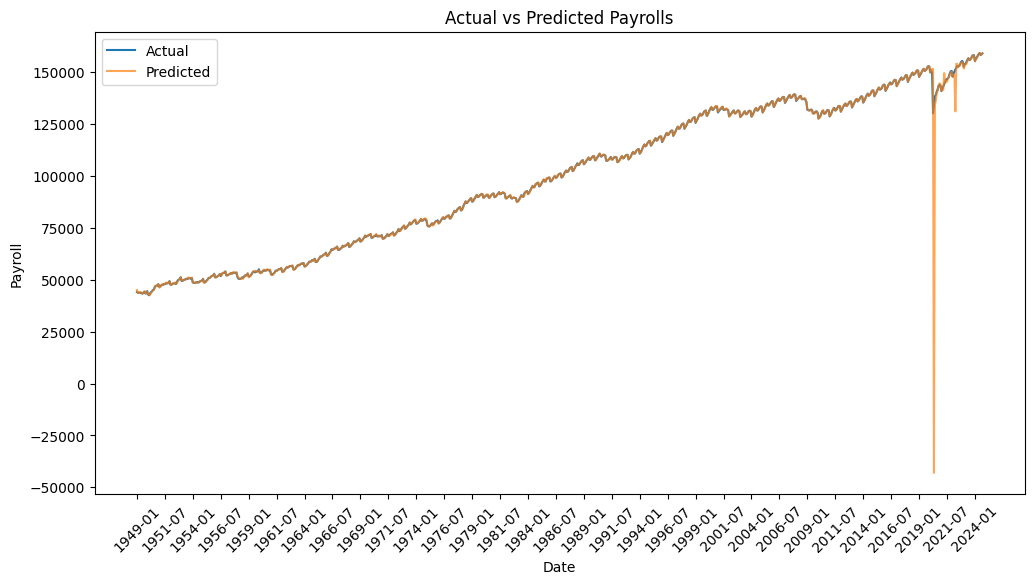

In [46]:
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Actual'], label='Actual')
plt.plot(results_df.index, results_df['Predicted'], label='Predicted', alpha=0.7)
plt.title('Actual vs Predicted Payrolls')
plt.xticks(results_df.index[::30], rotation = 45)
plt.xlabel('Date')
plt.ylabel('Payroll')
plt.legend()
plt.show()

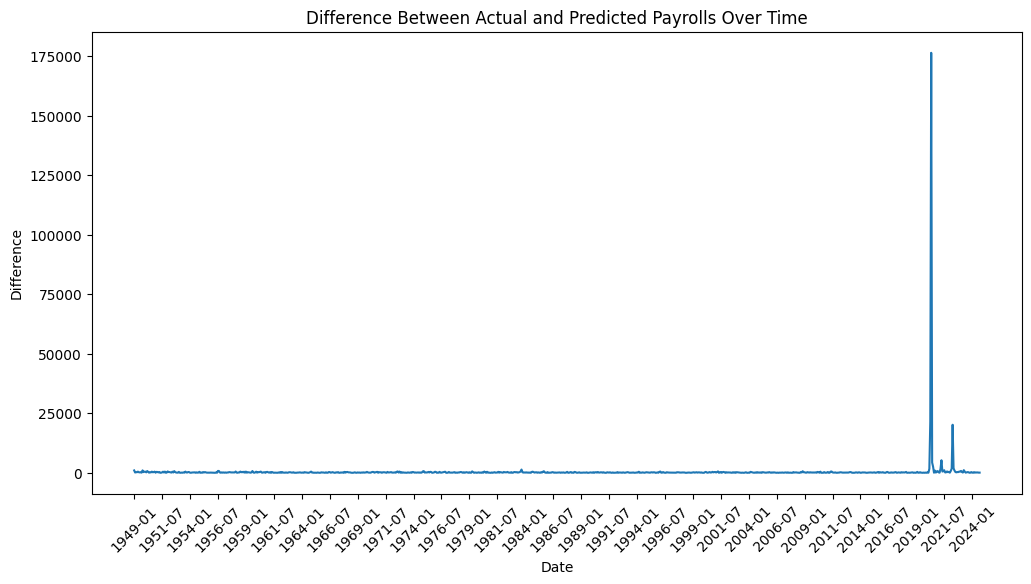

In [47]:
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Difference'])
plt.title('Difference Between Actual and Predicted Payrolls Over Time')
plt.xticks(results_df.index[::30], rotation = 45)
plt.xlabel('Date')
plt.ylabel('Difference')
plt.show()


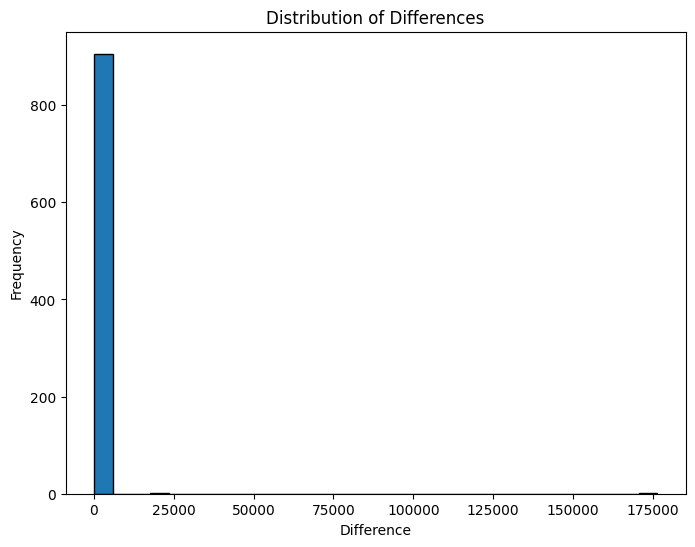

In [43]:
plt.figure(figsize=(8, 6))
plt.hist(results_df['Difference'], bins=30, edgecolor='k')
plt.title('Distribution of Differences')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()


In [44]:
# Set a threshold for significant differences (e.g., top 5% differences)
threshold = results_df['Difference'].quantile(0.95)

# Get dates with significant differences
significant_errors = results_df[results_df['Difference'] >= threshold]

print("Dates with significant differences:")
print(significant_errors)


Dates with significant differences:
         Actual      Predicted     Difference
Date                                         
1949-01   44159   45158.346759     999.346759
1949-10   43447   44457.945966    1010.945966
1950-03   43410   42663.146727     746.853273
1951-10   48550   48033.628376     516.371624
1952-01   47659   48242.340580     583.340580
1952-08   49077   48357.854559     719.145441
1956-07   51847   52634.885947     787.885947
1956-08   52802   52040.614830     761.385170
1958-02   50588   51138.592144     550.592144
1959-01   51721   51201.900628     519.099372
1959-08   53636   54376.837391     740.837391
1972-08   74054   73491.899536     562.100464
1972-10   75290   74759.281198     530.718802
1974-11   79060   79643.367238     583.367238
1974-12   78419   79133.471072     714.471072
1979-04   89313   89914.798129     601.798129
1980-05   90763   91303.813548     540.813548
1983-08   89998   90584.201528     586.201528
1983-09   91719   90349.821247    1369.17875